In [2]:
import torch.nn as nn
import torch
from learning_warmstarts.opti_problem.gen_problem import generate_problem_v2    

class IpoptLossV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
        self.problem = generate_problem_v2()
        self.def_options = {"print_time": False, "ipopt": {"max_iter": 1, "print_level": 0}}
        self.ws_options = {"print_time": False, "ipopt": {"max_iter": 1, 'print_level': 0,         
                    'warm_start_init_point': 'yes',
                    'warm_start_bound_frac': 1e-16,
                    'warm_start_bound_push': 1e-16,
                    'warm_start_mult_bound_push': 1e-16,
                    'warm_start_slack_bound_frac': 1e-16,
                    'warm_start_slack_bound_push': 1e-16,}}
        self.converged = False
        self.x_warmstart = None
        self.lamg_warmstart = None

        self.mse = nn.MSELoss(reduction="mean")

    def forward(self,predictions, inputs):
        if self.converged:
            self.converged = False
            self.x_warmstart = None
            self.lamg_warmstart = None
    
        inputs = inputs.numpy()

        self.problem.set_value(self.problem.p[:-1], inputs)
        
        if self.x_warmstart is not None and self.lamg_warmstart is not None:
            self.problem.set_initial(self.problem.x, self.x_warmstart)
            self.problem.set_initial(self.problem.lam_g, self.lamg_warmstart) 
            self.problem.solver("ipopt", self.ws_options)
        else:
            self.problem.solver("ipopt", self.def_options)

        try:
            solution = self.problem.solve()
            target = solution.value(self.problem.x)
            self.converged = True
            print('IPOPT Converged... moving to next sample') 
        except RuntimeError:
            target = self.problem.debug.value(self.problem.x)
            self.x_warmstart = self.problem.debug.value(self.problem.x)
            self.lamg_warmstart = self.problem.debug.value(self.problem.lam_g)

        target = torch.from_numpy(target)
        target.requires_grad = False
        
        return self.mse(predictions, target.float())

In [3]:
import torch
from learning_warmstarts import problem_specs
from learning_warmstarts.neural_nets.models import FFNet
from learning_warmstarts.dataset.obst_avoidance_dataset import ObstacleAvoidanceDataset
from learning_warmstarts.viz import Visualizations
        
predict_dual_vars = False

model_file = 'ipopt-model.pt'

train_data = ObstacleAvoidanceDataset('../tiny_data/',False)
test_data = ObstacleAvoidanceDataset('../test_data/',False)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = None, batch_sampler=None)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = None, batch_sampler=None)


inputs = 4 + 3 * problem_specs['num_obstacles']
if predict_dual_vars:
    outputs = 6 * problem_specs['control_intervals'] + problem_specs['num_constraints']
else:    
    outputs = 6 * problem_specs['control_intervals']

shape = [inputs] + [1024] + [outputs]

model = FFNet(shape, torch.nn.functional.relu)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

criterion = IpoptLossV2()
    
def train(model, optimizer, criterion, train_loader):
    """ Train a simple FFNet on the training data 
        using mini-batch or stochastic gradient descent  
    """
    epochs = 1
    print('Starting Training...')

    t = torch.FloatTensor([problem_specs['interval_duration']])
    vis = Visualizations()

    for epoch in range(epochs):
        train_iters = 0
        test_iters = 0
        moving_avg_train_loss = 0
        moving_avg_test_loss = 0

        for x, y in train_loader:
            steps_on_problem = 0
            x = x.float()
            while not criterion.converged and steps_on_problem < 750:  
                steps_on_problem += 1
                prediction = model(x)
                loss = criterion(prediction, x)
                # print(f'Step {steps_on_problem} MSE: {loss.item()}')
                if loss.item() < 10 and steps_on_problem > 50:
                    vis.show_trajectory(criterion.x_warmstart[:160].tolist(),x[:4].tolist(), x[4:13])
                    criterion.converged = True

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                        
                moving_avg_train_loss = (loss.item() + train_iters * moving_avg_train_loss) / (train_iters + 1)
                train_iters += 1

            print(f'Final MSE after ipopt converged ({steps_on_problem} steps) for sample: {criterion(model(x),x).item()}')

    torch.save(model.state_dict(), model_file)

Starting Training...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

IPOPT Converged... moving to next sample
Final MSE after ipopt converged (18 steps) for sample: 2003.6793212890625
IPOPT Converged... moving to next sample
Final MSE after ipopt converged (33 steps) for sample: 39.59928512573242


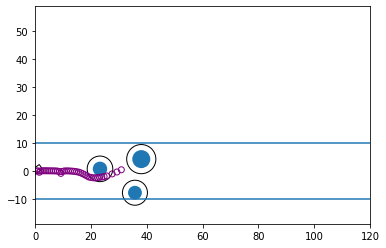

Final MSE after ipopt converged (57 steps) for sample: 10.931456565856934


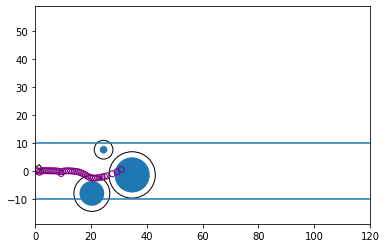

Final MSE after ipopt converged (51 steps) for sample: 0.9696156978607178


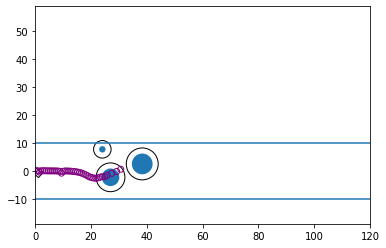

Final MSE after ipopt converged (51 steps) for sample: 2.879277467727661


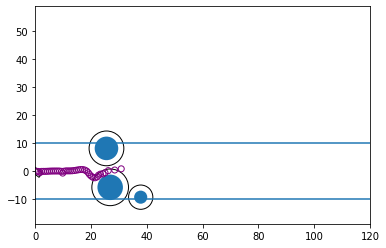

Final MSE after ipopt converged (51 steps) for sample: 1.9358065128326416


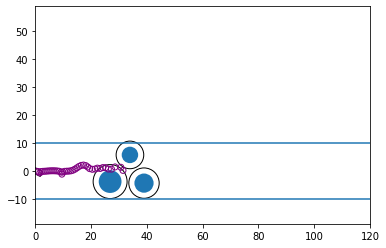

Final MSE after ipopt converged (51 steps) for sample: 2.6733620166778564


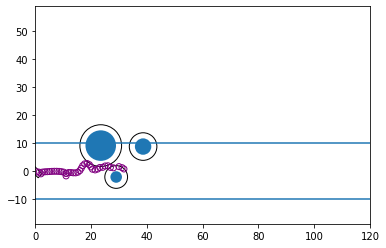

Final MSE after ipopt converged (51 steps) for sample: 1.6941488981246948


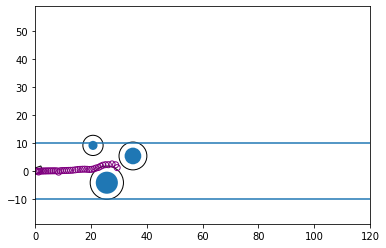

Final MSE after ipopt converged (51 steps) for sample: 6.676619052886963


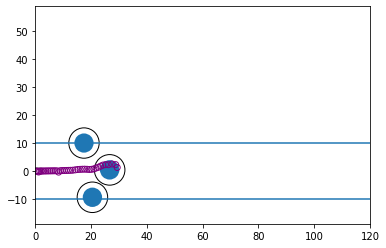

Final MSE after ipopt converged (51 steps) for sample: 1.6387059688568115


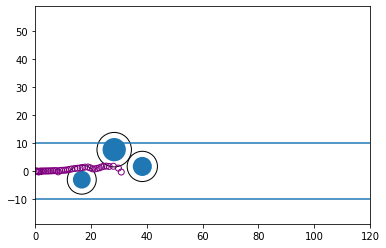

Final MSE after ipopt converged (53 steps) for sample: 7.56952428817749


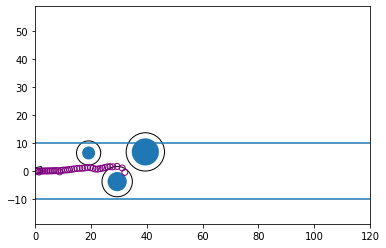

Final MSE after ipopt converged (51 steps) for sample: 3.6858291625976562
IPOPT Converged... moving to next sample
Final MSE after ipopt converged (56 steps) for sample: 11.112688064575195


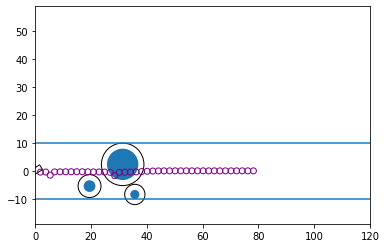

Final MSE after ipopt converged (51 steps) for sample: 8.578142166137695


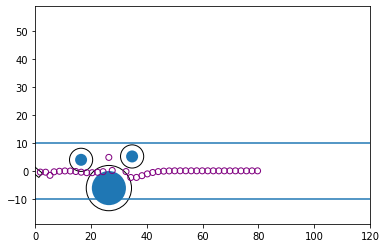

Final MSE after ipopt converged (53 steps) for sample: 5.763803482055664


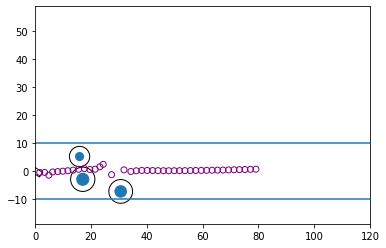

Final MSE after ipopt converged (51 steps) for sample: 9.3352689743042


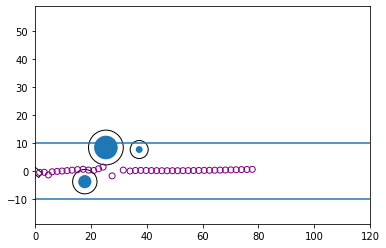

Final MSE after ipopt converged (51 steps) for sample: 6.6109538078308105


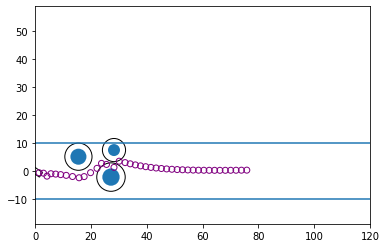

Final MSE after ipopt converged (51 steps) for sample: 2.6037280559539795


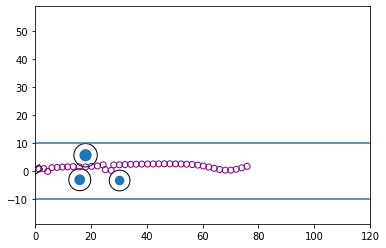

Final MSE after ipopt converged (51 steps) for sample: 2.017488956451416


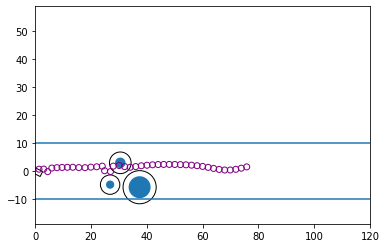

Final MSE after ipopt converged (51 steps) for sample: 3.9789810180664062


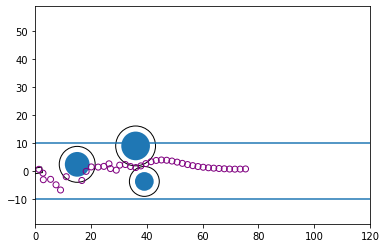

Final MSE after ipopt converged (60 steps) for sample: 6.611839771270752


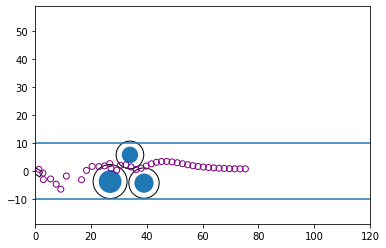

Final MSE after ipopt converged (51 steps) for sample: 1.7712851762771606


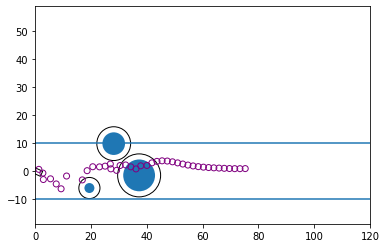

Final MSE after ipopt converged (51 steps) for sample: 7.973433494567871


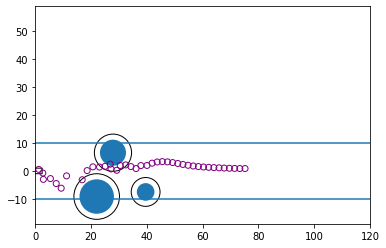

Final MSE after ipopt converged (51 steps) for sample: 4.2169880867004395


In [4]:
train(model, optimizer, criterion, train_loader)